In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.__version__)

2.9.1+cu126


In [44]:
from nik_io import load_event
from nik_model import NIK_SIREN2D_REIM
from nik_train import prepare_tensors, fit_one_frame_slice_coil, plot_measured_vs_pred_kspace, overfit_fixed_subset
from nik_recon import ifft1d_kz_to_z, make_fixed_frame_zslice_coil_dataset
import numpy as np
import random

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

k DCE shape :  (60, 392, 8, 220)
trajectory shape :  (60, 392, 3, 220)
Number of z slices: 7
Readouts per slice: 56
{'t_fixed': 0, 'coil_fixed': 0, 'z_slice_idx': 3, 'n_slices': 7, 'n_ro_per_slice': 56, 'N': 12320, 'y_scale': 41.970611572265625}


Overfitting fixed (t,kz,coil): 100%|█| 3000/3000 [04:31<00:00, 11.06it/s, mse=6.


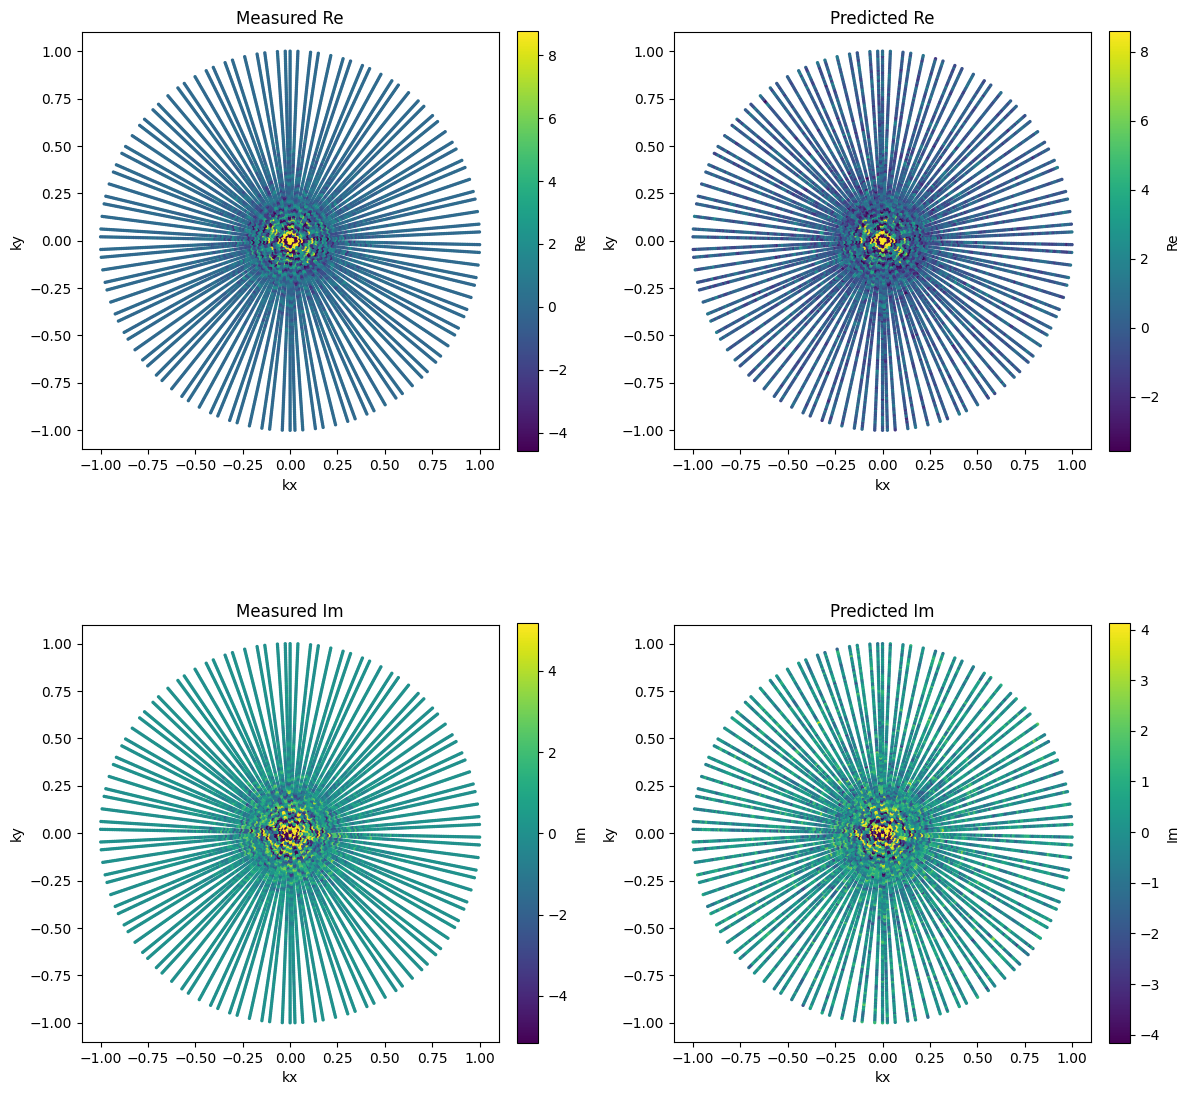

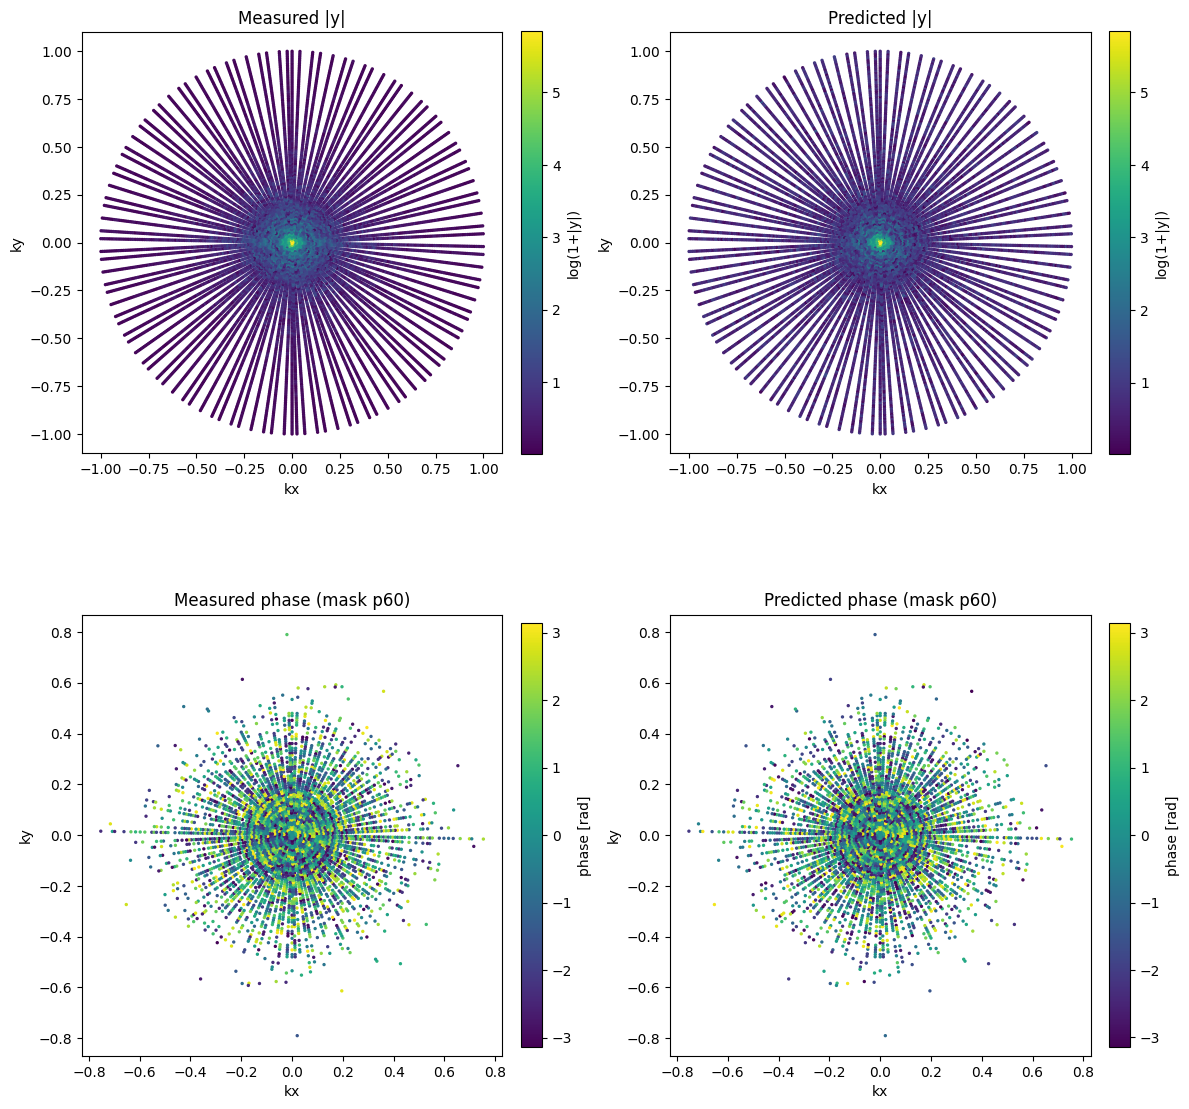

In [45]:


# Load data with images
event = load_event("../XCAT-ERIC/results/simulation_results_20260115T150400.mat", load_images=True)
k_np, traj_np = event["k"], event["traj"]
gt_img = event.get("gt_img")  # Ground truth images
rc_img = event.get("rc_img")  # Reconstructed images from file

# Set in expected dimension order
k_np = np.transpose(k_np, (0, 2, 1, 3))
traj_np = np.transpose(traj_np, (0, 2, 1, 3))

T, S, C, RO = k_np.shape
print("k DCE shape : ", k_np.shape)
print("trajectory shape : ", traj_np.shape)

k_t, traj_t, scales, dims, k_scale = prepare_tensors(k_np, traj_np, data_device="cuda")

# Select parameters
t_frame = 0  # Which time frame to reconstruct
coil_idx = 0  # Which coil to use
n_steps = 3000  # Training steps per slice
batch_size = 65536
lr = 1e-4

# iFFT kz -> z (interleaved spokes -> z slices)
k_img_space, n_z_slices, n_ro_per_slice, kz_sort_order = ifft1d_kz_to_z(k_t, traj_t, t_frame=t_frame)
print(f"Number of z slices: {n_z_slices}")
print(f"Readouts per slice: {n_ro_per_slice}")

z_slice_idx = n_z_slices // 2  # Middle z-slice


x_all, y_all, kx_all, ky_all, meta = make_fixed_frame_zslice_coil_dataset(
    k_img_space,
    traj_t,
    scales,
    dims,
    y_scale=k_scale,
    t_fixed=t_frame,
    coil_fixed=coil_idx,
    z_slice_idx=z_slice_idx,
    n_slices=n_z_slices,
    compute_device="cuda",
)
print(meta)

model = NIK_SIREN2D_REIM(
    n_coils=1,
    k_freq=64, k_sigma=3.0,
    t_freq=16, t_sigma=3.0,
    z_mode="linear", z_dim=16,
    hidden=256, depth=7, w0=30.0
).cuda()


model, info = fit_one_frame_slice_coil(
    model,
    x_all=x_all, y_all=y_all,
    coil_fixed=meta["coil_fixed"],
    steps=n_steps,
    batch_size=batch_size,
    lr=lr,
    amp=False,
    device="cuda",
    use_tqdm=True
)


plot_measured_vs_pred_kspace(model, x_all, y_all, kx_all, ky_all, coil_fixed=meta["coil_fixed"], y_scale = meta["y_scale"])


In [46]:
t = t_frame
G = n_z_slices
S = traj_t.shape[1]

idx0 = torch.arange(0, S, G, device=traj_t.device)
idx1 = torch.arange(1, S, G, device=traj_t.device)

dkx = (traj_t[t, idx0, 0, :] - traj_t[t, idx1, 0, :]).abs().max().item()
dky = (traj_t[t, idx0, 1, :] - traj_t[t, idx1, 1, :]).abs().max().item()
print("max |Δkx|:", dkx, "max |Δky|:", dky)

max |Δkx|: 0.0 max |Δky|: 0.0


In [47]:
# pick one frame
t = t_frame

kx = traj_t[t, :, 0, :]
ky = traj_t[t, :, 1, :]

print("kx min/max:", kx.min().item(), kx.max().item())
print("ky min/max:", ky.min().item(), ky.max().item())


kx min/max: -0.4998936057090759 0.4998936057090759
ky min/max: -0.5 0.5


In [48]:
kz = traj_t[0, :, 2, 0]   # (S,)
unique_kz = torch.unique(kz)

print("Number of spokes S:", kz.numel())
print("Unique kz values:", unique_kz.numel())
print("First 10 kz values:", kz[:10].cpu().numpy())
print("Unique kz (sorted):", torch.sort(unique_kz).values.cpu().numpy())


Number of spokes S: 392
Unique kz values: 7
First 10 kz values: [4. 5. 3. 6. 2. 7. 1. 4. 5. 3.]
Unique kz (sorted): [1. 2. 3. 4. 5. 6. 7.]


In [49]:
# approximate kz_samples from trajectory
kz_unique_sorted = torch.sort(unique_kz).values
print(kz_unique_sorted)


tensor([1., 2., 3., 4., 5., 6., 7.], device='cuda:0')


In [50]:
kx_flat = kx.reshape(-1).cpu().numpy()
ky_flat = ky.reshape(-1).cpu().numpy()

r = np.sqrt(kx_flat**2 + ky_flat**2)

print("radius min/max:", r.min(), r.max())
print("sqrt(radius) min/max:", np.sqrt(r).min(), np.sqrt(r).max())



radius min/max: 0.002283105 0.5
sqrt(radius) min/max: 0.047781847 0.70710677


In [51]:
# Automatically get image size from loaded data
if gt_img is not None:
    print(gt_img.shape)
    img_size = gt_img.shape[2:4]
elif rc_img is not None:
    print(rc_img.shape)
    img_size = rc_img.shape[2:4]
else:
    img_size = (128, 128)  # fallback
print(f"Using image size: {img_size}")


oversamp =  1 # 1 is no oversampling

Nx0, Ny0 = img_size
Ny_os, Nx_os = oversamp * Ny0, oversamp * Nx0

z_const = x_all[0, 2]   # z_norm used in training
t_const = x_all[0, 3]   # t_norm used in training

kx_lin = torch.linspace(-kx_max, kx_max, Nx_os, device="cuda")
ky_lin = torch.linspace(-ky_max, ky_max, Ny_os, device="cuda")
KY, KX = torch.meshgrid(ky_lin, kx_lin, indexing="ij")  # (Ny_os, Nx_os)

kx_flat = KX.reshape(-1)
ky_flat = KY.reshape(-1)
z_col = z_const.expand(Ny_os * Nx_os)
t_col = t_const.expand(Ny_os * Nx_os)

x_query = torch.stack([kx_flat, ky_flat, z_col, t_col], dim=1).float()



(121, 7, 220, 152)
Using image size: (220, 152)


In [52]:
with torch.no_grad():
    model.eval()
    coil_model_idx = 0  # if n_coils=1
    coil_vec = torch.full((x_query.shape[0],), coil_model_idx, device="cuda", dtype=torch.long)
    y_pred = model(x_query, coil_vec) * k_scale
    k_cart = torch.complex(y_pred[:, 0], y_pred[:, 1]).reshape(Ny_os, Nx_os)


print("Prediction complete for one z-slice!")


Prediction complete for one z-slice!


In [58]:
from nik_recon import nufft2d_recon, fft2d_uniform


print(k_img_space_pred.shape)

#  Reconstruct from MODEL predicted k-space (after kz->z IFFT)
print("Reconstructing from model predictions...")
mask = ((KX / kx_max) ** 2 + (KY / ky_max) ** 2) <= 1.0
k_cart = k_cart * mask

"""
# Reduce noise by smoothening
r = torch.sqrt((KX/kx_max)**2 + (KY/ky_max)**2)  # 0..~1 in disk
w = 0.5 * (1.0 + torch.cos(np.pi * torch.clamp(r, 0, 1)))  # Hann: 1 at center, 0 at edge
w = w * (((KX/kx_max)**2 + (KY/ky_max)**2) <= 1.0)         # keep disk only

k_cart_win = k_cart * w
"""

img_os = fft2d_uniform(k_cart, axes=(-2, -1), shift=True, return_magnitude=True)

# crop center back to original size
y0 = (Ny_os - Ny0) // 2
x0 = (Nx_os - Nx0) // 2
img_pred = img_os[y0:y0 + Ny0, x0:x0 + Nx0]


# 2. Reconstruct from MEASURED k-space (after kz->z IFFT)
print("Reconstructing from measured k-space...")
img_measured = nufft2d_recon(
    k_img_space, traj_t,
    t_frame=t_frame,
    coil_idx=coil_idx,
    z_slice_idx=z_slice_idx,
    scales=scales,
    img_size=img_size,
    n_slices=n_z_slices,
)

# 3. Extract reconstructed image from file (if available)
if rc_img is not None:
    img_recon_file = rc_img[t_frame, z_slice_idx, :, :]
else:
    img_recon_file = None

# 4. Extract ground truth from file (if available)
if gt_img is not None:
    img_gt_file = gt_img[t_frame, z_slice_idx, :, :]
else:
    img_gt_file = None


torch.Size([60, 56, 8, 7, 220])
Reconstructing from model predictions...
Reconstructing from measured k-space...


img_gt_file shape: (220, 152)
dtype: float32


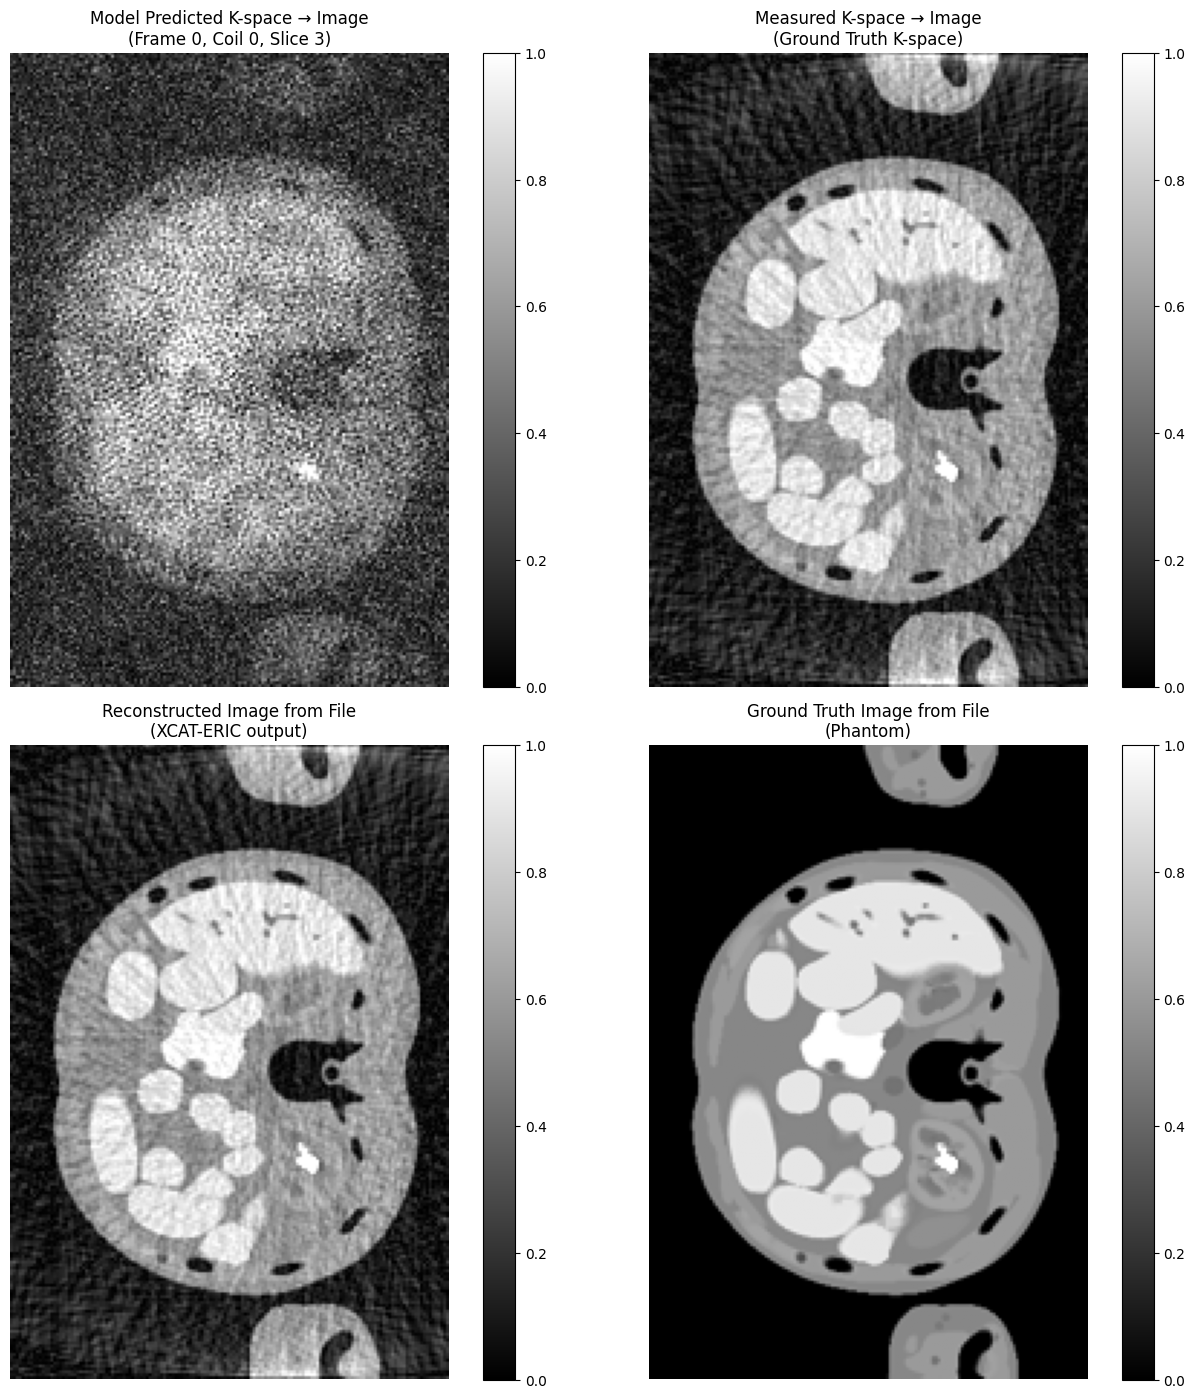

In [59]:
import matplotlib.pyplot as plt
from nik_recon import to_plot, norm_img

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

img_pred = to_plot(img_pred).transpose()
img_pred = norm_img(img_pred)

# 1. Model prediction reconstruction
im0 = axes[0, 0].imshow(img_pred, cmap='gray', vmin=0, vmax=np.percentile(img_pred, 99))
axes[0, 0].set_title(f'Model Predicted K-space → Image\n(Frame {t_frame}, Coil {coil_idx}, Slice {z_slice_idx})')
axes[0, 0].axis('off')
plt.colorbar(im0, ax=axes[0, 0], fraction=0.046)

# 2. Measured k-space reconstruction
img_measured = norm_img(img_measured)
im1 = axes[0, 1].imshow(img_measured, cmap='gray', vmin=0, vmax=np.percentile(img_measured, 99))
axes[0, 1].set_title('Measured K-space → Image\n(Ground Truth K-space)')
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

# 3. File reconstructed image
if img_recon_file is not None:
    print("img_gt_file shape:", img_gt_file.shape)
    print("dtype:", img_gt_file.dtype)
    img_recon_file = norm_img(img_recon_file)
    im2 = axes[1, 0].imshow(img_recon_file, cmap='gray', vmin=0, vmax=np.percentile(img_recon_file, 99))
    axes[1, 0].set_title('Reconstructed Image from File\n(XCAT-ERIC output)')
    axes[1, 0].axis('off')
    plt.colorbar(im2, ax=axes[1, 0], fraction=0.046)
else:
    axes[1, 0].text(0.5, 0.5, 'Not Available', ha='center', va='center', fontsize=14)
    axes[1, 0].set_title('Reconstructed Image from File')
    axes[1, 0].axis('off')

# 4. Ground truth image
if img_gt_file is not None:
    img_gt_file = norm_img(img_gt_file)
    im3 = axes[1, 1].imshow(img_gt_file, cmap='gray', vmin=0, vmax=np.percentile(img_gt_file, 99))
    axes[1, 1].set_title('Ground Truth Image from File\n(Phantom)')
    axes[1, 1].axis('off')
    plt.colorbar(im3, ax=axes[1, 1], fraction=0.046)
else:
    axes[1, 1].text(0.5, 0.5, 'Not Available', ha='center', va='center', fontsize=14)
    axes[1, 1].set_title('Ground Truth Image from File')
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [60]:
print("\n" + "="*60)
print("RECONSTRUCTION QUALITY METRICS")
print("="*60)

# Normalize images for fair comparison
def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

img_pred_norm = normalize(img_pred)
img_meas_norm = normalize(img_measured)

# MSE between model and measured (NumPy)
mse = np.mean((img_meas_norm.ravel() - img_pred_norm.ravel())**2)
print(f"\nMSE (Model vs Measured): {mse:.6f}")

# NRMSE
nrmse = np.sqrt(mse)
print(f"NRMSE (Model vs Measured): {nrmse:.6f}")

# Peak SNR
psnr = 20 * np.log10(1.0 / (nrmse + 1e-8))
print(f"PSNR (Model vs Measured): {psnr:.2f} dB")

# Correlation
corr = np.corrcoef(img_meas_norm.ravel(), img_pred_norm.ravel())[0, 1]
print(f"Correlation (Model vs Measured): {corr:.4f}")

if img_gt_file is not None:
    img_gt_norm = normalize(img_gt_file)

    mse_pred_gt = np.mean((img_gt_norm.ravel() - img_pred_norm.ravel())**2)
    mse_meas_gt = np.mean((img_gt_norm.ravel() - img_meas_norm.ravel())**2)

    print(f"\nMSE (Model vs Ground Truth): {mse_pred_gt:.6f}")
    print(f"MSE (Measured vs Ground Truth): {mse_meas_gt:.6f}")
    print(f"Model improvement: {((mse_meas_gt - mse_pred_gt)/mse_meas_gt)*100:.2f}%")

print("="*60)



RECONSTRUCTION QUALITY METRICS

MSE (Model vs Measured): 0.017077
NRMSE (Model vs Measured): 0.130678
PSNR (Model vs Measured): 17.68 dB
Correlation (Model vs Measured): 0.7038

MSE (Model vs Ground Truth): 0.015733
MSE (Measured vs Ground Truth): 0.001489
Model improvement: -956.86%


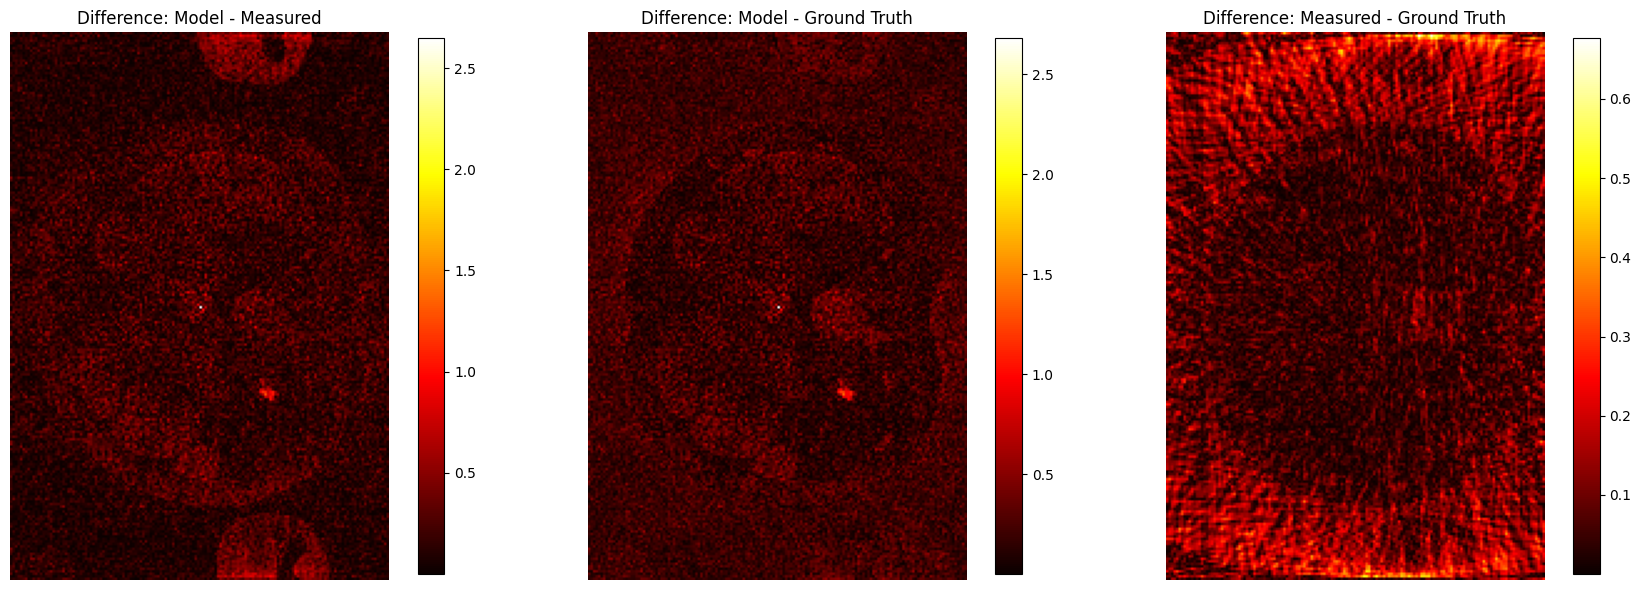

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Difference: Model vs Measured
diff_model_meas = np.abs(img_pred - img_measured)
im0 = axes[0].imshow(diff_model_meas, cmap='hot')
axes[0].set_title('Difference: Model - Measured')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

if img_gt_file is not None:
    # Difference: Model vs GT
    diff_model_gt = np.abs(img_pred - img_gt_file)
    im1 = axes[1].imshow(diff_model_gt, cmap='hot')
    axes[1].set_title('Difference: Model - Ground Truth')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046)
    
    # Difference: Measured vs GT
    diff_meas_gt = np.abs(img_measured - img_gt_file)
    im2 = axes[2].imshow(diff_meas_gt, cmap='hot')
    axes[2].set_title('Difference: Measured - Ground Truth')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.show()